## Libraries and Prerequisite

In [74]:
import tensorflow as tf
#tensorflow.random.set_seed(x)
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam
#from keras.optimizers import Adam
from keras.backend import clear_session
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook
from tqdm import tqdm
from numpy.random import seed
#from tensorflow import set_random_seed
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import *

## Parameters

In [75]:
#Data Parameters
num_of_classes = 25
data_shape = (8,1)

#MLP Parameters
times_to_run = 25 #Number of times to run MLP model
mlp_epochs = 20
valid_split = 0.10

#GAN Parameters
latent_dim = 50
gan_epochs = 2500

#Random Seeds
selection_seed = 75
seed_multiplier = 500000

In [76]:
cb1 = widgets.Checkbox(description="Generate missing data only")
slider1 = widgets.FloatSlider(value=0.8, min=0.05, max=1, step=0.05)
slider2 = widgets.IntSlider(value=125, min=0, max=625, step=125)
vb = VBox(children = [slider2])
def checkbox(button):
    if button['new']:
        vb.children = []
        slider2.value = 25 - int(slider1.value*250) 
    else:
        vb.children = [slider2]
        experiment3 = False
cb1.observe(checkbox, names='value')

print("Percentage of Real Data:")
display(slider1)
print("Number of datapoints GAN generates:")
display(vb)
display(cb1)


Percentage of Real Data:


FloatSlider(value=0.8, max=1.0, min=0.05, step=0.05)

Number of datapoints GAN generates:


Checkbox(value=False, description='Generate missing data only')

In [77]:
fraction_of_data = slider1.value
data_to_gen = slider2.value

In [78]:
data_to_gen

125

## Data preprocessing


In [79]:
dataset = pd.read_csv("./data/new_dataset_rssi_2.csv")
labels = dataset.Class.values
labels = labels - 1 #Original label values are from 1 to 25
features = dataset.drop(columns='Class').values
len(features)


1251

In [80]:
tr_fea, X_test, tr_label, Y_test = train_test_split(features, 
                                                    labels, 
                                                    test_size=0.5,
                                                    random_state= selection_seed,
                                                    stratify=labels)


In [81]:
Y_test


array([18,  4, 18, 18, 16, 24,  3,  1, 20, 10,  8, 14,  7, 24,  0, 11, 21,
        4, 17, 11, 11, 23,  8, 23,  9, 11, 12,  5, 18, 16, 21, 10, 10,  4,
        9,  3, 17, 19,  4, 24, 20, 20, 16,  4, 11, 23, 23,  3, 18, 10, 16,
       21, 22, 15, 23, 12, 20,  6, 19, 13, 18, 11, 18,  1,  6,  3, 21, 22,
        1,  3, 20, 15,  9, 12,  2,  3, 14, 15,  5, 17,  0,  0, 13, 16, 17,
       16, 23,  4, 18,  1, 17,  1, 15, 15, 14,  8,  0, 20, 23,  3,  9, 10,
       14,  4, 11,  7,  6,  9, 13, 17,  2, 14, 11,  3,  4,  8,  9, 10, 21,
        2, 15, 15,  1, 10, 11, 11,  4,  6,  3,  6,  8, 20, 10, 19, 10, 21,
       22, 19, 12, 13, 16, 20, 13,  3,  9,  1, 15, 15,  1,  2, 22,  1, 17,
        7, 17, 24,  6,  2,  9,  6,  9, 12, 23, 12, 18, 22,  0,  7, 16,  4,
       18, 22,  8, 17, 14, 15, 24,  5,  0, 21, 15, 15, 21, 15, 12, 24,  5,
        5, 16, 22, 22, 11, 19,  9, 14, 21,  2,  6, 10,  7, 15, 22,  7, 12,
       11, 18, 18, 10,  8,  7, 13, 19,  3, 16, 21, 17,  7, 13, 11, 21, 18,
       19, 13,  5,  0, 12

In [82]:
X_train = []
Z_train = [] #This is the same as X_train, but it's used for training the GAN
Y_train = []

for idx in range(25):
    number_filter = np.where(tr_label == idx)
    X_filtered, Y_filtered = tr_fea[number_filter], tr_label[number_filter]

    num_of_data = (int)(fraction_of_data*X_filtered.shape[0])
    RandIndex = np.random.choice(X_filtered.shape[0], 
                                 num_of_data, 
                                 replace=False)
    Z_train.append(X_filtered[RandIndex])
    X_train.extend(X_filtered[RandIndex])
    Y_train.extend(Y_filtered[RandIndex])

X_train = np.asarray(X_train, dtype=np.float32)
Y_train = np.asarray(Y_train, dtype=np.float32)

X_train, Y_train = shuffle(X_train, Y_train)

Y_train_encoded = to_categorical(Y_train)
Y_test_encoded = to_categorical(Y_test)

In [83]:
#Data must be standized using standard scaler before using the MLP.
scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.fit_transform(X_test)

In [84]:
len(X_train_transformed)

500

# Classification with MLP for Real Data

In [85]:
all_test_loss =[]
all_test_acc = []
history = []

for i in tqdm_notebook(range(times_to_run)):
    seed(i*seed_multiplier)
    #set_random_seed(i*seed_multiplier)
    tf.random.set_seed(i*seed_multiplier)

    model = Sequential()
    model.add(Dense(200, input_shape=(8,), activation='relu'))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(25, activation='softmax'))
    model.compile(optimizer=Adam(0.0002, 0.5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    history_temp = model.fit(X_train_transformed,
                            Y_train_encoded,
                            epochs=mlp_epochs,
                            batch_size=64,
                            validation_split=valid_split,
                            verbose=0)
    history.append(history_temp)
    test_loss, test_acc = model.evaluate(X_test_transformed, 
                                         Y_test_encoded, 
                                         verbose=0)

    all_test_acc.append(test_acc)
    all_test_loss.append(test_loss)
    del(model)
    clear_session()

C:\Users\KMITL\AppData\Local\Temp/ipykernel_19028/3153672149.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(times_to_run)):


  0%|          | 0/25 [00:00<?, ?it/s]

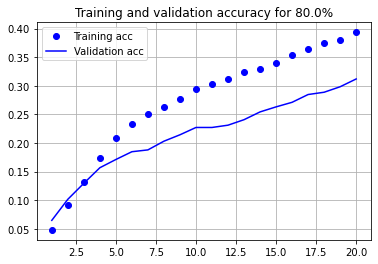

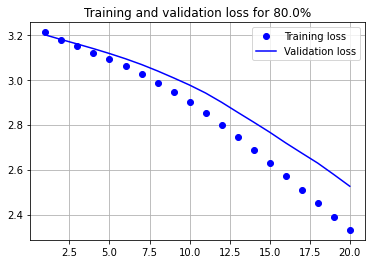

In [86]:
trainacc = []
trainloss = []
valacc = []
valloss = []
for i in range (len(history)):
    trainacc.append(history[i].history['accuracy'])
    trainloss.append(history[i].history['loss'])
    valacc.append(history[i].history['val_accuracy'])
    valloss.append(history[i].history['val_loss'])

acc = np.mean(trainacc, axis=0)
val_acc = np.mean(valacc, axis=0)
loss = np.mean(trainloss, axis=0)
val_loss = np.mean(valloss, axis=0)
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy for {}%'.format(fraction_of_data*100))
plt.legend()
plt.grid()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for {}%'.format(fraction_of_data*100))
plt.legend()
plt.grid()
plt.savefig("./results/original/Train - {}%.png".format(fraction_of_data*100))

# Generating Synthetic Data


In [87]:
def build_generator():
    model = Sequential()
    
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(data_shape), activation='tanh'))
    model.add(Reshape(data_shape))

    #model.summary()

    noise = Input(shape=(latent_dim,))
    gendata = model(noise)
    
    return Model(noise, gendata)

In [88]:
def build_discriminator():

    model = Sequential()

    model.add(Flatten(input_shape=data_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))

    #model.summary()

    data = Input(shape=data_shape)
    validity = model(data)

    return Model(data, validity)

In [89]:
def train(epochs, features, batch_size=128):

    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
            idx = np.random.randint(0, features.shape[0], batch_size)
            data = features[idx]

            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            gen_data = generator.predict(noise)

            d_loss_real = discriminator.train_on_batch(data, valid)
            d_loss_fake = discriminator.train_on_batch(gen_data, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            g_loss = combined.train_on_batch(noise, valid)

**Training GAN**

In [90]:
gen_data = []

for i in tqdm(range(num_of_classes)):
    discriminator = build_discriminator()
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=Adam(0.0002, 0.5),
                          metrics=['accuracy'])
    
    generator = build_generator()
    noise = Input(shape=(latent_dim,))
    gendata = generator(noise)
    discriminator.trainable = False
    validity = discriminator(gendata)
    combined = Model(noise, validity)
    combined.compile(loss='binary_crossentropy',
                    optimizer=Adam(0.0002, 0.5))

    minimaxscaler = MinMaxScaler((-1,1))
    Z_train_transformed = minimaxscaler.fit_transform(Z_train[i])
    Z_train_transformed = np.expand_dims(Z_train_transformed, axis=2)

    train(epochs=gan_epochs,
          features=Z_train_transformed,
          batch_size=64)
        
    noise = np.random.normal(0, 1, (data_to_gen, latent_dim))
    gen_data_temp = generator.predict(noise)
    gen_data_temp = np.asarray(gen_data_temp, dtype=np.float32)
    gen_data_temp = np.squeeze(gen_data_temp)
    gen_data_temp = minimaxscaler.inverse_transform(gen_data_temp)

    gen_data.append(gen_data_temp)

    clear_session()
    del(discriminator)
    del(generator)
    del(combined)

gen_data = np.asarray(gen_data, dtype=np.float32)

100%|██████████| 25/25 [1:27:02<00:00, 208.90s/it]


# Classification with MLP for Real + Synthetic Data

**Preprocess synthetic data**

In [91]:
gen_label = []
for i in range(25):
    gen_label_temp = np.tile(i, data_to_gen)
    gen_label.extend(gen_label_temp)

gen_label = np.asarray(gen_label, dtype=np.float32)
gen_label_encoded = to_categorical(gen_label)

In [92]:
gen_data_reshaped = gen_data.reshape(num_of_classes*data_to_gen, data_shape[0])

X_train_gan, Y_train_gan = shuffle(gen_data_reshaped,
                                   gen_label_encoded, 
                                   random_state=5)


In [93]:
df=pd.DataFrame(gen_data_reshaped)
df.to_csv("syn_dataset_joko125 - {}%.csv".format(fraction_of_data*100))#edit

In [94]:
new_x_train = np.concatenate((X_train, X_train_gan), axis=0)
new_y_train = np.concatenate((Y_train_encoded, Y_train_gan), axis=0)

new_x_train, new_y_train = shuffle(new_x_train, new_y_train, random_state=15)
new_x_train_transformed = scaler.fit_transform(new_x_train)

**Train a new MLP on Real+Synthetic Data**

In [95]:
all_test_loss_gan =[]
all_test_acc_gan = []
ganhistory = []

for i in tqdm_notebook(range(50)):
    seed(i*seed_multiplier)
    tf.random.set_seed(i*seed_multiplier)

    model = Sequential()
    model.add(Dense(200, input_shape=(8,), activation='relu'))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(25, activation='softmax'))

    model.compile(optimizer=Adam(0.0002, 0.5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    ganhistorytemp = model.fit(new_x_train_transformed,
                    new_y_train,
                    epochs=mlp_epochs,
                    batch_size=64,
                    validation_split=valid_split,
                    verbose = 0)
    ganhistory.append(ganhistorytemp)

    test_loss, test_acc = model.evaluate(X_test_transformed, 
                                         Y_test_encoded, 
                                         verbose=0)
    print("#{} Test acc:".format(i), test_acc)

    all_test_acc_gan.append(test_acc)
    all_test_loss_gan.append(test_loss)
    del(model)
    clear_session()

C:\Users\KMITL\AppData\Local\Temp/ipykernel_19028/4255249426.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(50)):


  0%|          | 0/50 [00:00<?, ?it/s]

#0 Test acc: 0.7428115010261536
#1 Test acc: 0.7284345030784607
#2 Test acc: 0.7220447063446045
#3 Test acc: 0.7236421704292297
#4 Test acc: 0.725239634513855
#5 Test acc: 0.720447301864624
#6 Test acc: 0.7172523736953735
#7 Test acc: 0.7076677083969116
#8 Test acc: 0.7460063695907593
#9 Test acc: 0.7172523736953735
#10 Test acc: 0.7396166324615479
#11 Test acc: 0.7316293716430664
#12 Test acc: 0.7348242998123169
#13 Test acc: 0.7236421704292297
#14 Test acc: 0.7476038336753845
#15 Test acc: 0.7124600410461426
#16 Test acc: 0.7316293716430664
#17 Test acc: 0.7284345030784607
#18 Test acc: 0.7300319671630859
#19 Test acc: 0.7092651724815369
#20 Test acc: 0.720447301864624
#21 Test acc: 0.7220447063446045
#22 Test acc: 0.7300319671630859
#23 Test acc: 0.7316293716430664
#24 Test acc: 0.7332268357276917
#25 Test acc: 0.7076677083969116
#26 Test acc: 0.7236421704292297
#27 Test acc: 0.7268370389938354
#28 Test acc: 0.7507987022399902
#29 Test acc: 0.7396166324615479
#30 Test acc: 0.7092651

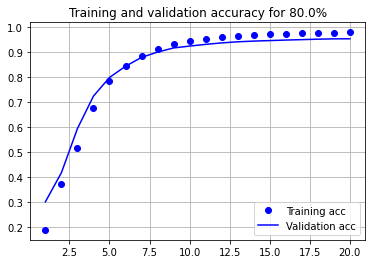

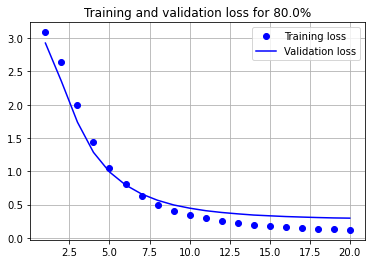

In [96]:
gantrainacc = []
gantrainloss = []
ganvalacc = []
ganvalloss = []
for i in range (len(ganhistory)):
    gantrainacc.append(ganhistory[i].history['accuracy']) #val accuracy
    gantrainloss.append(ganhistory[i].history['loss'])
    ganvalacc.append(ganhistory[i].history['val_accuracy'])
    ganvalloss.append(ganhistory[i].history['val_loss'])

gan_acc = np.mean(gantrainacc, axis=0)
gan_val_acc = np.mean(ganvalacc, axis=0)
gan_loss = np.mean(gantrainloss, axis=0)
gan_val_loss = np.mean(ganvalloss, axis=0)
epochs = range(1, len(gan_acc) + 1)
plt.plot(epochs, gan_acc, 'bo', label='Training acc')
plt.plot(epochs, gan_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy for {}%'.format(fraction_of_data*100))
plt.legend()
plt.grid()
plt.figure()
plt.plot(epochs, gan_loss, 'bo', label='Training loss')
plt.plot(epochs, gan_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for {}%'.format(fraction_of_data*100))
plt.legend()
plt.grid()
plt.savefig("./results/GAN/Train_Joko - {}%.png".format(fraction_of_data*100)) #edit

# Save Results

In [97]:
AccMean = np.mean(all_test_acc)
LossMean = np.mean(all_test_loss)
AccStd = np.std(all_test_acc)
LossStd = np.std(all_test_loss)

GanAccMean = np.mean(all_test_acc_gan)
GanLossMean = np.mean(all_test_loss_gan)
GanAccStd = np.std(all_test_acc_gan)
GanLossStd = np.std(all_test_loss_gan)

lines  = list()
lines.append("Original Data (Each Class: {} Real):".format(num_of_data))
lines.append("Accuracy mean: {}".format(AccMean))
lines.append("Loss mean: {}".format(LossMean))
lines.append("Accuracy STD: {}".format(AccStd))
lines.append("Loss STD: {} \n".format(LossStd))
lines.append("Maximum Accuracy: {}".format(np.max(all_test_acc)))
lines.append("Loss of Maximum Accuracy: {}".format(
    all_test_loss[np.argmax(all_test_acc)]))

lines.append("\n ================== \n")
lines.append("Original + GAN Data" +
             "(Each Class: {} Real + {} GAN):".format(num_of_data, 
                                                      data_to_gen))
lines.append("Accuracy mean: {}".format(GanAccMean))
lines.append("Loss mean: {}".format(GanLossMean))
lines.append("Accuracy STD: {}".format(GanAccStd))
lines.append("Loss STD: {} \n".format(GanLossStd))
lines.append("Maximum Accuracy: {}".format(np.max(all_test_acc_gan)))
lines.append("Loss of Maximum Accuracy: {}".format(
    all_test_loss_gan[np.argmax(all_test_acc_gan)]))


file_dir = "./results/Test_Joko125 - {}%.txt".format(fraction_of_data*100)
with open(file_dir, "w") as filehandle:
    for items in lines:
        filehandle.write('%s\n' % items)